**UPLOAD THE DATASET**


In [ ]:
# ====== Setup Cell ======
# Install extra libraries (only needed once)
!pip install scikit-image seaborn matplotlib

# Mount Google Drive (uncomment if dataset is in Drive)
#from google.colab import drive
#drive.mount('/content/drive')

# Upload dataset zip file (if not using Drive)
from google.colab import files
uploaded = files.upload()

# If uploaded, unzip it (adjust filename if needed)
!unzip dataset.zip -d dataset

print("✅ Setup complete.")

Saving dataset_split.zip to dataset_split.zip
unzip:  cannot find or open dataset.zip, dataset.zip.zip or dataset.zip.ZIP.
✅ Setup complete. Now run Block 1 (LBP Feature Extraction).


In [ ]:
import os

# List all files in current directory
print(os.listdir())

# Pick the correct zip file name from the list

['.config', 'dataset_split.zip', 'sample_data']


In [ ]:
import zipfile
import os

zip_path = "dataset_split.zip"  # use the correct file

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(".")

# Check folder structure
print(os.listdir("dataset_split"))

['train', 'test']


**PREPROCESSING**
1. Resizing to 128x128
2. Gray Scale Conversion
3. Normalization

In [ ]:
# _____________________________PREPROCESSING_____________________________
import os
import cv2
import numpy as np

DATASET_DIR = "dataset_split"
IMG_SIZE = (128, 128)

def preprocess_images(folder, class_names):
    images, labels, paths = [], [], []
    for label, class_name in enumerate(class_names):
        class_path = os.path.join(folder, class_name)
        if not os.path.isdir(class_path):
            continue
        for img_file in sorted(os.listdir(class_path)):  # ensure consistent order
            img_path = os.path.join(class_path, img_file)

            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue

            img = cv2.resize(img, IMG_SIZE)
            img = img.astype("float32") / 255.0

            images.append(img)
            labels.append(label)
            paths.append(img_path)  # save path for later
    return np.array(images), np.array(labels), np.array(paths)

# -------------------------------
# MAIN
# -------------------------------
train_dir = os.path.join(DATASET_DIR, "train")
test_dir = os.path.join(DATASET_DIR, "test")

class_names = sorted(os.listdir(train_dir))

X_train, y_train, train_paths = preprocess_images(train_dir, class_names)
X_test, y_test, test_paths = preprocess_images(test_dir, class_names)

np.savez_compressed("preprocessed_dataset.npz",
                    X_train=X_train, y_train=y_train,
                    X_test=X_test, y_test=y_test,
                    train_paths=train_paths, test_paths=test_paths,
                    class_names=class_names)

print("✅ Preprocessing complete and saved with image paths!")
print("Train set:", X_train.shape, y_train.shape)
print("Test set :", X_test.shape, y_test.shape)


✅ Preprocessing complete and saved with image paths!
Train set: (2049, 128, 128) (2049,)
Test set : (515, 128, 128) (515,)


**VISUALIZATION [ORIGINAL -> PREPROCESSED IMAGE]**

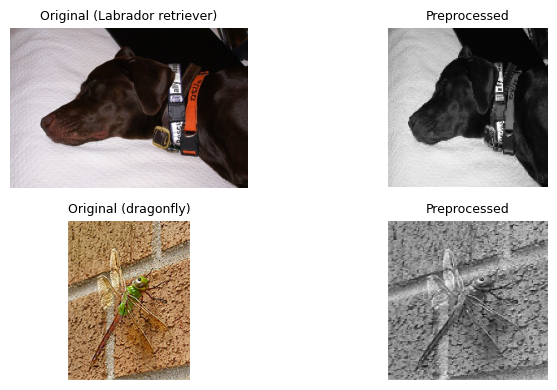

In [ ]:
# _____________________________PREPROCESSING VISUALIZATION_____________________________
import numpy as np
import matplotlib.pyplot as plt
import cv2

data = np.load("preprocessed_dataset.npz", allow_pickle=True)

X_train, y_train = data["X_train"], data["y_train"]
train_paths = data["train_paths"]
class_names = data["class_names"]

plt.figure(figsize=(8, 4))

for i in range(2):  # show 2 samples
    idx = np.random.randint(0, X_train.shape[0])
    label = class_names[y_train[idx]]
    pre_img = X_train[idx]

    # Load exact original image
    orig_rgb = cv2.imread(train_paths[idx])
    orig_rgb = cv2.cvtColor(orig_rgb, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 2, i*2 + 1)
    plt.imshow(orig_rgb)
    plt.title(f"Original ({label})", fontsize=9)
    plt.axis("off")

    plt.subplot(2, 2, i*2 + 2)
    plt.imshow(pre_img, cmap="gray")
    plt.title("Preprocessed", fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()


**Before Extracting the features using Canny Edge detection, We used Gaussian Blur**

In [ ]:
# _____________________________GAUSSIAN BLUR (PROCESSING)_____________________________
import numpy as np
import cv2

# -------------------------------
# LOAD PREPROCESSED DATA
# -------------------------------
data = np.load("preprocessed_dataset.npz", allow_pickle=True)

X_train, y_train = data["X_train"], data["y_train"]
X_test, y_test = data["X_test"], data["y_test"]
train_paths, test_paths = data["train_paths"], data["test_paths"]
class_names = data["class_names"]

# Remove channel dimension if present
X_train_gray = X_train.squeeze()
X_test_gray = X_test.squeeze()

# -------------------------------
# APPLY GAUSSIAN BLUR
# -------------------------------
def apply_gaussian_blur(images):
    return np.array([cv2.GaussianBlur(img, (5, 5), 0) for img in images])

X_train_blur = apply_gaussian_blur(X_train_gray)
X_test_blur = apply_gaussian_blur(X_test_gray)

# -------------------------------
# SAVE BLURRED DATA
# -------------------------------
np.savez_compressed("blurred_dataset.npz",
                    X_train_blur=X_train_blur, y_train=y_train,
                    X_test_blur=X_test_blur, y_test=y_test,
                    train_paths=train_paths, test_paths=test_paths,
                    class_names=class_names)

print("✅ Gaussian Blur complete and saved!")
print("Train (blur):", X_train_blur.shape, y_train.shape)
print("Test (blur) :", X_test_blur.shape, y_test.shape)


✅ Gaussian Blur complete and saved!
Train (blur): (2049, 128, 128) (2049,)
Test (blur) : (515, 128, 128) (515,)


**VISUALIZATION [ORG. IMAGE, PREPROCESSED IMAGE, GAUSSIAN BLURRED IMAGE]**

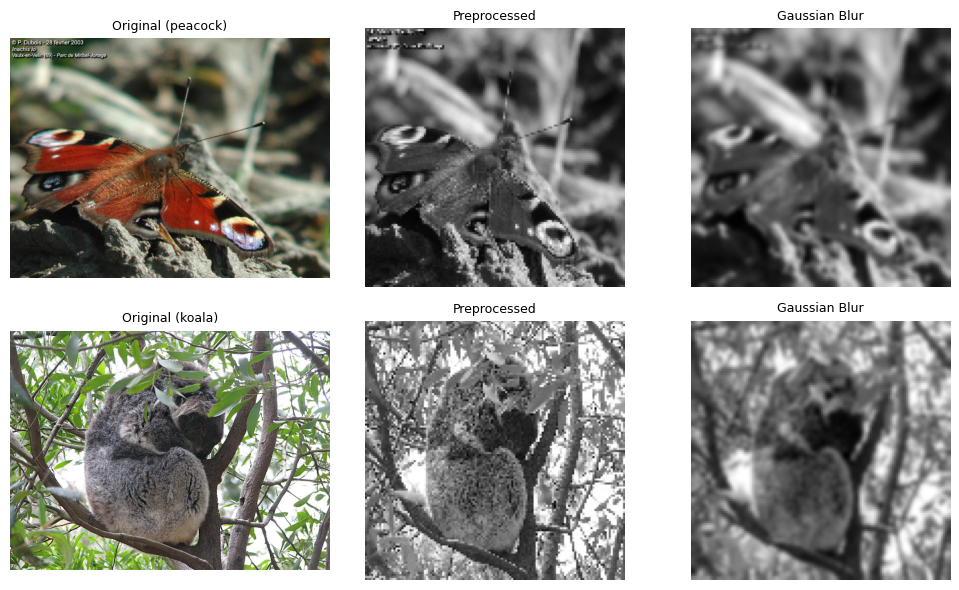

In [ ]:
# _____________________________GAUSSIAN BLUR VISUALIZATION_____________________________
import numpy as np
import cv2
import matplotlib.pyplot as plt

# -------------------------------
# LOAD PREPROCESSED + BLURRED DATA
# -------------------------------
pre_data = np.load("preprocessed_dataset.npz", allow_pickle=True)
blur_data = np.load("blurred_dataset.npz", allow_pickle=True)

X_train_pre = pre_data["X_train"].squeeze()
y_train = pre_data["y_train"]
train_paths = pre_data["train_paths"]
class_names = pre_data["class_names"]

X_train_blur = blur_data["X_train_blur"]

# -------------------------------
# VISUALIZE (2 RANDOM SAMPLES)
# -------------------------------
plt.figure(figsize=(10, 6))

for i in range(2):  # Show 2 samples
    idx = np.random.randint(0, X_train_pre.shape[0])
    pre_img = X_train_pre[idx]
    blurred_img = X_train_blur[idx]
    label = class_names[y_train[idx]]

    # Load exact original image (RGB)
    orig_rgb = cv2.imread(train_paths[idx])
    orig_rgb = cv2.cvtColor(orig_rgb, cv2.COLOR_BGR2RGB)

    # --- Original
    plt.subplot(2, 3, i*3 + 1)
    plt.imshow(orig_rgb)
    plt.title(f"Original ({label})", fontsize=9)
    plt.axis("off")

    # --- Preprocessed
    plt.subplot(2, 3, i*3 + 2)
    plt.imshow(pre_img, cmap="gray")
    plt.title("Preprocessed", fontsize=9)
    plt.axis("off")

    # --- Gaussian Blur
    plt.subplot(2, 3, i*3 + 3)
    plt.imshow(blurred_img, cmap="gray")
    plt.title("Gaussian Blur", fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()


**Extracting the Features using Canny Edge detection**

In [ ]:
# _____________________________EDGE DETECTION (PROCESSING)_____________________________
import numpy as np
import cv2

# -------------------------------
# LOAD BLURRED DATA
# -------------------------------
blur_data = np.load("blurred_dataset.npz", allow_pickle=True)

X_train_blur, y_train = blur_data["X_train_blur"], blur_data["y_train"]
X_test_blur, y_test = blur_data["X_test_blur"], blur_data["y_test"]
train_paths, test_paths = blur_data["train_paths"], blur_data["test_paths"]
class_names = blur_data["class_names"]

# -------------------------------
# APPLY CANNY EDGE DETECTION
# -------------------------------
def apply_canny(images, low_thresh=100, high_thresh=200):
    return np.array([
        cv2.Canny((img * 255).astype("uint8"), low_thresh, high_thresh).flatten()
        for img in images
    ])

X_train_edges = apply_canny(X_train_blur)
X_test_edges = apply_canny(X_test_blur)

# -------------------------------
# SAVE EDGE FEATURE DATA
# -------------------------------
np.savez_compressed("edge_features_dataset.npz",
                    X_train_edges=X_train_edges, y_train=y_train,
                    X_test_edges=X_test_edges, y_test=y_test,
                    train_paths=train_paths, test_paths=test_paths,
                    class_names=class_names)

print("✅ Edge Detection complete and saved!")
print("Train (edges):", X_train_edges.shape, y_train.shape)
print("Test (edges) :", X_test_edges.shape, y_test.shape)


✅ Edge Detection complete and saved!
Train (edges): (2049, 16384) (2049,)
Test (edges) : (515, 16384) (515,)


**Visualization after Extracting the Features
 [ORG.IMAGE, PREPROCESSED IMAGE, GAUSSIAN BLURRED IMAGE, IMAGE AFTER EDGE DETECTION]**

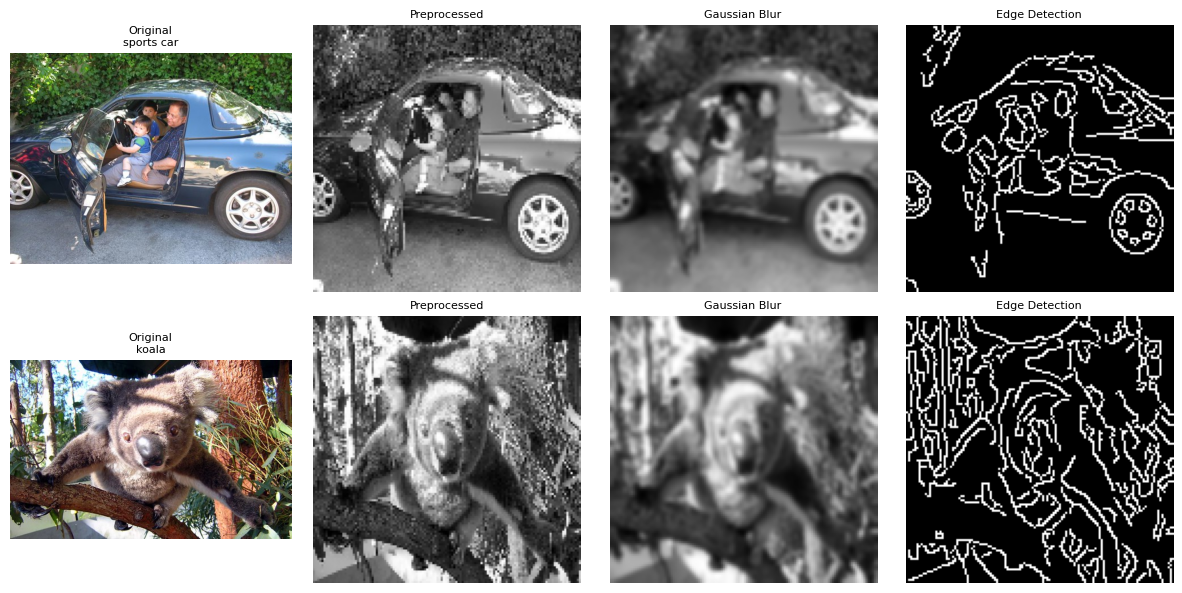

In [ ]:
# _____________________________EDGE DETECTION VISUALIZATION_____________________________
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random

# -------------------------------
# LOAD PREPROCESSED + BLURRED + EDGE DATA
# -------------------------------
pre_data = np.load("preprocessed_dataset.npz", allow_pickle=True)
blur_data = np.load("blurred_dataset.npz", allow_pickle=True)
edge_data = np.load("edge_features_dataset.npz", allow_pickle=True)

X_train_pre, y_train = pre_data["X_train"], pre_data["y_train"]
X_train_blur = blur_data["X_train_blur"]
X_train_edges = edge_data["X_train_edges"]
train_paths = edge_data["train_paths"]
class_names = edge_data["class_names"]

# Remove channel dimension if present
X_train_pre = X_train_pre.squeeze()

# -------------------------------
# VISUALIZATION (2 RANDOM SAMPLES)
# -------------------------------
plt.figure(figsize=(12, 6))

for i in range(2):
    idx = random.randint(0, len(X_train_pre) - 1)

    # Load original in RGB
    orig_rgb = cv2.imread(train_paths[idx])
    orig_rgb = cv2.cvtColor(orig_rgb, cv2.COLOR_BGR2RGB)

    preprocessed_img = X_train_pre[idx]
    blurred_img = X_train_blur[idx]
    edge_img = X_train_edges[idx].reshape(preprocessed_img.shape)

    # --- Original ---
    plt.subplot(2, 4, i * 4 + 1)
    plt.imshow(orig_rgb)
    plt.title(f"Original\n{class_names[y_train[idx]]}", fontsize=8)
    plt.axis("off")

    # --- Preprocessed ---
    plt.subplot(2, 4, i * 4 + 2)
    plt.imshow(preprocessed_img, cmap="gray")
    plt.title("Preprocessed", fontsize=8)
    plt.axis("off")

    # --- Gaussian Blur ---
    plt.subplot(2, 4, i * 4 + 3)
    plt.imshow(blurred_img, cmap="gray")
    plt.title("Gaussian Blur", fontsize=8)
    plt.axis("off")

    # --- Edge Detection ---
    plt.subplot(2, 4, i * 4 + 4)
    plt.imshow(edge_img, cmap="gray")
    plt.title("Edge Detection", fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()


**LOGISTIC REGRESSION CLASSIFIER**

✅ Loaded edge feature dataset
Train: (2049, 16384) (2049,)
Test : (515, 16384) (515,)
Classes: ['African elephant' 'Egyptian cat' 'German shepherd' 'Labrador retriever'
 'dragonfly' 'golden retriever' 'gorilla' 'koala' 'monarch' 'peacock'
 'rose' 'sports car']


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to co


📊 Classification Report:
                    precision    recall  f1-score   support

  African elephant       0.18      0.16      0.17        50
      Egyptian cat       1.00      0.06      0.12        16
   German shepherd       0.00      0.00      0.00        38
Labrador retriever       0.14      0.18      0.16        60
         dragonfly       0.27      0.37      0.31        54
  golden retriever       0.22      0.22      0.22        46
           gorilla       0.00      0.00      0.00        20
             koala       0.31      0.47      0.37        70
           monarch       0.32      0.46      0.38        68
           peacock       0.27      0.23      0.25        40
              rose       0.17      0.04      0.06        25
        sports car       0.11      0.07      0.09        28

          accuracy                           0.24       515
         macro avg       0.25      0.19      0.18       515
      weighted avg       0.23      0.24      0.22       515



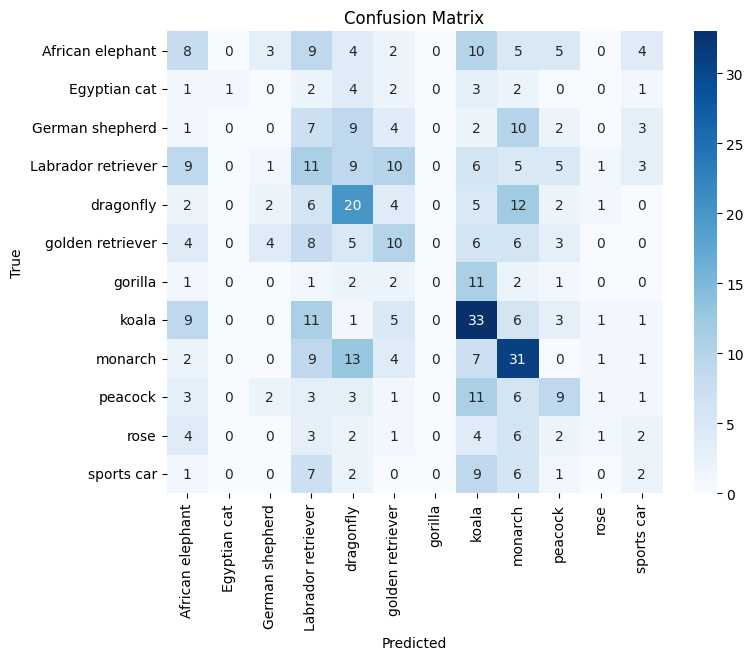

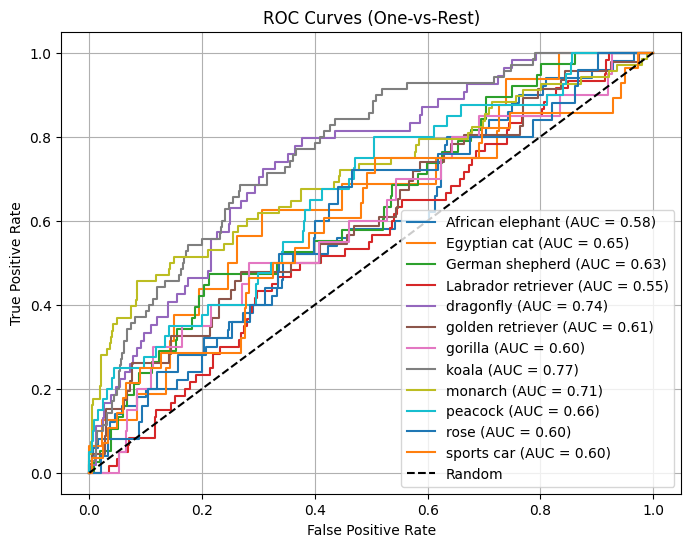


 Extra Metrics:
Matthews Corr Coeff : 0.1518
Log Loss            : 2.7712


In [ ]:
# ____________________________TRAIN & EVALUATION (LOGISTIC REGRESSION)_____________________________
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    matthews_corrcoef, log_loss
)
from sklearn.preprocessing import label_binarize

# -------------------------------
# LOAD EDGE FEATURES DATA
# -------------------------------
data = np.load("edge_features_dataset.npz", allow_pickle=True)

X_train = data["X_train_edges"]
y_train = data["y_train"]
X_test = data["X_test_edges"]
y_test = data["y_test"]
class_names = data["class_names"]

print("✅ Loaded edge feature dataset")
print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)
print("Classes:", class_names)

# -------------------------------
# TRAIN LOGISTIC REGRESSION
# -------------------------------
clf = LogisticRegression(
    max_iter=500, solver='saga', penalty='l2', multi_class='multinomial'
)
clf.fit(X_train, y_train)

# -------------------------------
# PREDICTIONS
# -------------------------------
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

# -------------------------------
# METRICS - Classification Report
# -------------------------------
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

# -------------------------------
# CONFUSION MATRIX
# -------------------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# -------------------------------
# ROC-AUC CURVE (One-vs-Rest)
# -------------------------------
y_test_bin = label_binarize(y_test, classes=np.arange(len(class_names)))
n_classes = y_test_bin.shape[1]

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.title("ROC Curves (One-vs-Rest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# -------------------------------
# EXTRA INNOVATIVE METRICS
# -------------------------------
print("\n Extra Metrics:")
print(f"Matthews Corr Coeff : {matthews_corrcoef(y_test, y_pred):.4f}")
print(f"Log Loss            : {log_loss(y_test, y_prob):.4f}")


**KNN CLASSIFIER**

✅ Loaded edge feature dataset
Train: (2049, 16384) (2049,)
Test : (515, 16384) (515,)
Classes: ['African elephant' 'Egyptian cat' 'German shepherd' 'Labrador retriever'
 'dragonfly' 'golden retriever' 'gorilla' 'koala' 'monarch' 'peacock'
 'rose' 'sports car']

📊 Classification Report:
                    precision    recall  f1-score   support

  African elephant       0.17      0.08      0.11        50
      Egyptian cat       0.00      0.00      0.00        16
   German shepherd       0.00      0.00      0.00        38
Labrador retriever       0.13      0.92      0.22        60
         dragonfly       0.00      0.00      0.00        54
  golden retriever       0.11      0.07      0.08        46
           gorilla       0.00      0.00      0.00        20
             koala       0.00      0.00      0.00        70
           monarch       0.00      0.00      0.00        68
           peacock       0.00      0.00      0.00        40
              rose       0.00      0.00      0.00   

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


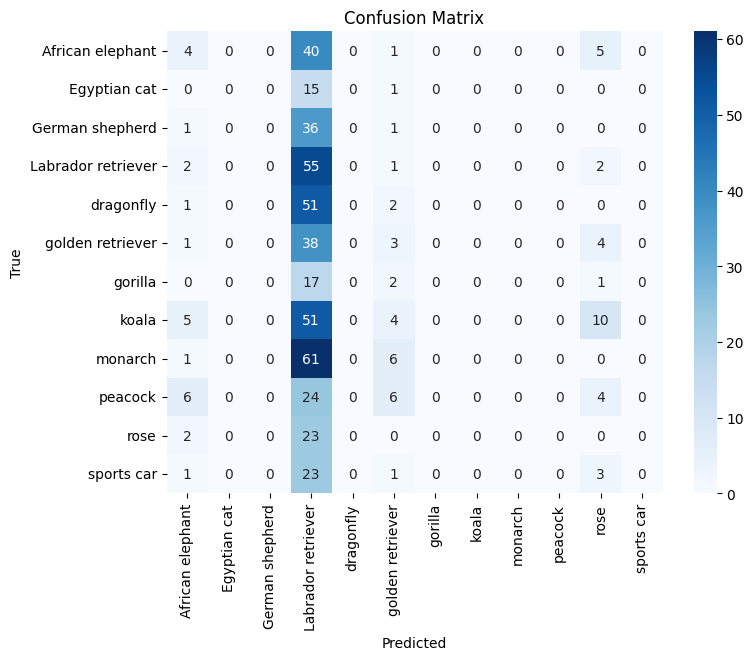

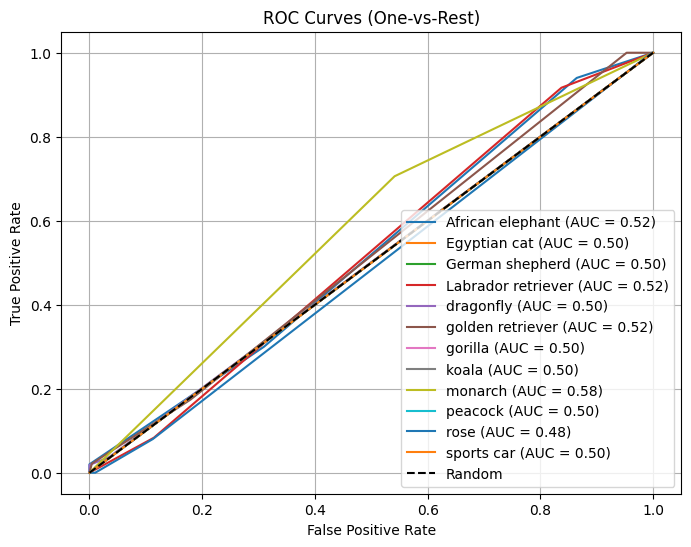


✨ Additional Metrics:
Matthews Corr Coeff : 0.0200
Log Loss            : 17.4437


In [ ]:
# ____________________________TRAIN & EVALUATION (KNN CLASSIFIER)_____________________________
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    matthews_corrcoef, log_loss
)
from sklearn.preprocessing import label_binarize

# -------------------------------
# LOAD EDGE FEATURES DATA
# -------------------------------
data = np.load("edge_features_dataset.npz", allow_pickle=True)

X_train = data["X_train_edges"]
y_train = data["y_train"]
X_test = data["X_test_edges"]
y_test = data["y_test"]
class_names = data["class_names"]

print("✅ Loaded edge feature dataset")
print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)
print("Classes:", class_names)

# -------------------------------
# TRAIN KNN
# -------------------------------
knn = KNeighborsClassifier(n_neighbors=10, metric="euclidean")  # You can tune n_neighbors
knn.fit(X_train, y_train)

# -------------------------------
# PREDICTIONS
# -------------------------------
y_pred = knn.predict(X_test)
y_prob = knn.predict_proba(X_test)

# -------------------------------
# METRICS - Classification Report
# -------------------------------
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

# -------------------------------
# CONFUSION MATRIX
# -------------------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# -------------------------------
# ROC-AUC CURVE (One-vs-Rest)
# -------------------------------
y_test_bin = label_binarize(y_test, classes=np.arange(len(class_names)))
n_classes = y_test_bin.shape[1]

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.title("ROC Curves (One-vs-Rest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# -------------------------------
# EXTRA METRICS
# -------------------------------
print("\n✨ Additional Metrics:")
print(f"Matthews Corr Coeff : {matthews_corrcoef(y_test, y_pred):.4f}")
print(f"Log Loss            : {log_loss(y_test, y_prob):.4f}")


**DECISION TREE CLASSIFIER**

✅ Loaded edge feature dataset
Train: (2049, 16384) (2049,)
Test : (515, 16384) (515,)
Classes: ['African elephant' 'Egyptian cat' 'German shepherd' 'Labrador retriever'
 'dragonfly' 'golden retriever' 'gorilla' 'koala' 'monarch' 'peacock'
 'rose' 'sports car']

📊 Classification Report:
                    precision    recall  f1-score   support

  African elephant       0.08      0.12      0.09        50
      Egyptian cat       0.00      0.00      0.00        16
   German shepherd       0.04      0.03      0.03        38
Labrador retriever       0.14      0.17      0.16        60
         dragonfly       0.16      0.17      0.16        54
  golden retriever       0.14      0.13      0.14        46
           gorilla       0.00      0.00      0.00        20
             koala       0.22      0.20      0.21        70
           monarch       0.21      0.19      0.20        68
           peacock       0.06      0.05      0.05        40
              rose       0.04      0.04      0.04   

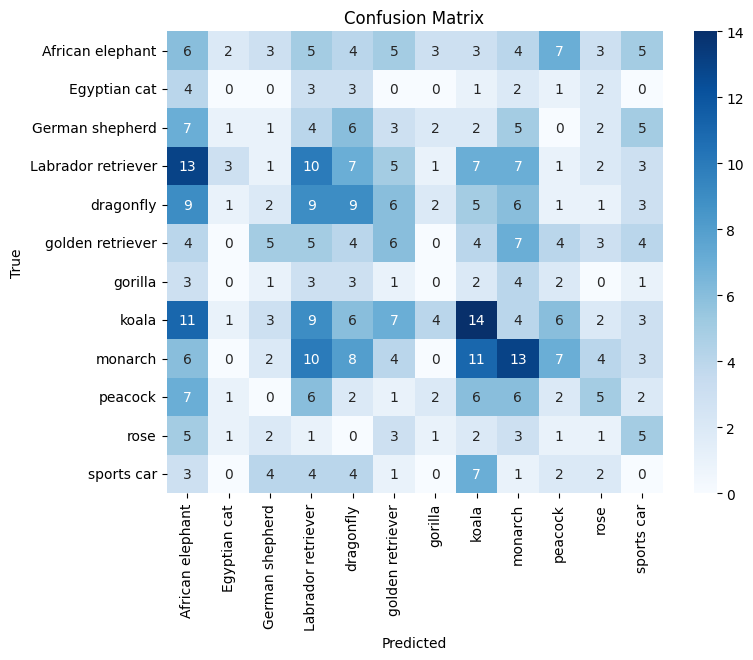

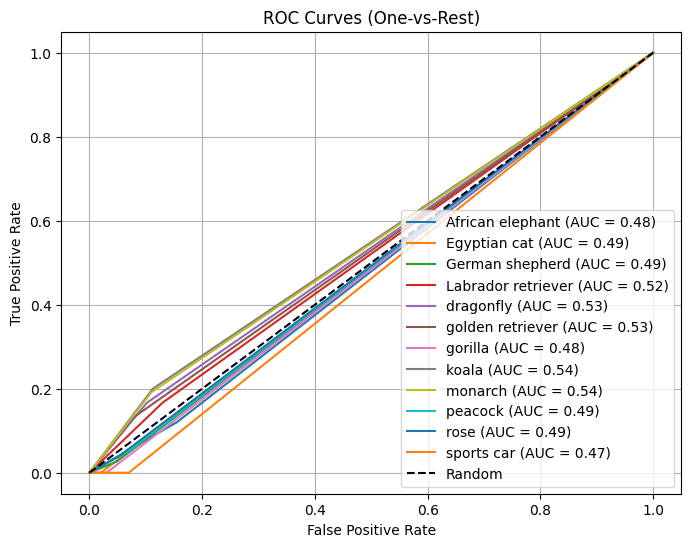


✨ Additional Metrics:
Matthews Corr Coeff : 0.0246
Log Loss            : 31.7044


In [ ]:
# ____________________________TRAIN & EVALUATION (DECISION TREE CLASSIFIER)_____________________________
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    matthews_corrcoef, log_loss
)
from sklearn.preprocessing import label_binarize

# -------------------------------
# LOAD EDGE FEATURES DATA
# -------------------------------
data = np.load("edge_features_dataset.npz", allow_pickle=True)

X_train = data["X_train_edges"]
y_train = data["y_train"]
X_test = data["X_test_edges"]
y_test = data["y_test"]
class_names = data["class_names"]

print("✅ Loaded edge feature dataset")
print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)
print("Classes:", class_names)

# -------------------------------
# TRAIN DECISION TREE
# -------------------------------
dt = DecisionTreeClassifier(
    criterion="gini",  # or "entropy"
    max_depth=None,    # you can limit depth to avoid overfitting
    random_state=42
)
dt.fit(X_train, y_train)

# -------------------------------
# PREDICTIONS
# -------------------------------
y_pred = dt.predict(X_test)
y_prob = dt.predict_proba(X_test)

# -------------------------------
# METRICS - Classification Report
# -------------------------------
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

# -------------------------------
# CONFUSION MATRIX
# -------------------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# -------------------------------
# ROC-AUC CURVE (One-vs-Rest)
# -------------------------------
y_test_bin = label_binarize(y_test, classes=np.arange(len(class_names)))
n_classes = y_test_bin.shape[1]

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.title("ROC Curves (One-vs-Rest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# -------------------------------
# EXTRA METRICS
# -------------------------------
print("\n✨ Additional Metrics:")
print(f"Matthews Corr Coeff : {matthews_corrcoef(y_test, y_pred):.4f}")
print(f"Log Loss            : {log_loss(y_test, y_prob):.4f}")


**RANDOM FOREST CLASSIFIER**

✅ Loaded edge feature dataset
Train: (2049, 16384) (2049,)
Test : (515, 16384) (515,)
Classes: ['African elephant' 'Egyptian cat' 'German shepherd' 'Labrador retriever'
 'dragonfly' 'golden retriever' 'gorilla' 'koala' 'monarch' 'peacock'
 'rose' 'sports car']

📊 Classification Report:
                    precision    recall  f1-score   support

  African elephant       0.22      0.18      0.20        50
      Egyptian cat       0.00      0.00      0.00        16
   German shepherd       0.40      0.05      0.09        38
Labrador retriever       0.14      0.23      0.17        60
         dragonfly       0.19      0.31      0.23        54
  golden retriever       0.05      0.04      0.04        46
           gorilla       0.00      0.00      0.00        20
             koala       0.29      0.50      0.37        70
           monarch       0.38      0.59      0.46        68
           peacock       0.25      0.05      0.08        40
              rose       0.00      0.00      0.00   

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


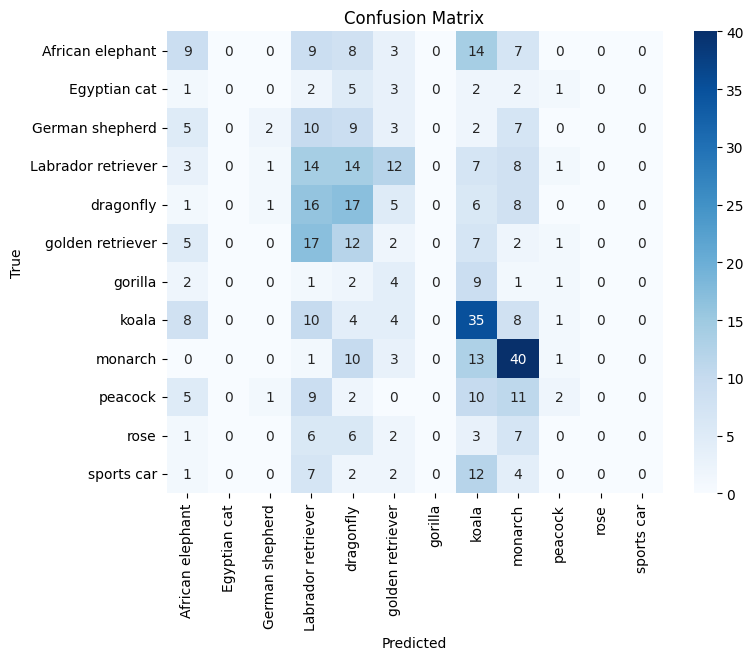

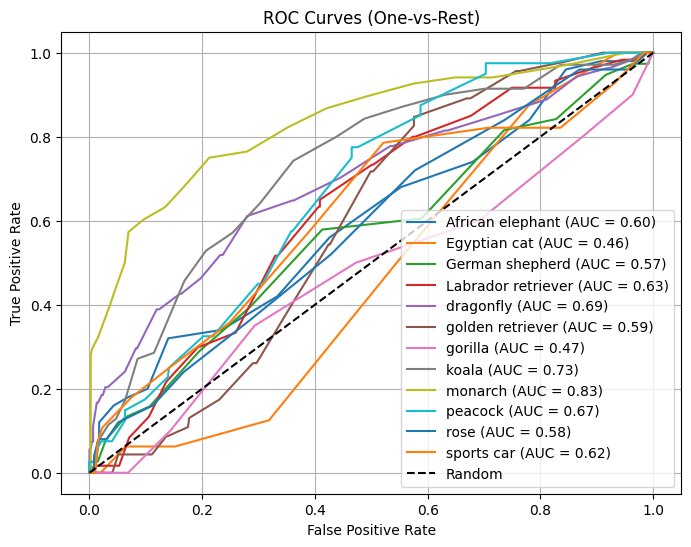


✨ Additional Metrics:
Matthews Corr Coeff : 0.1367
Log Loss            : 2.4061


In [ ]:
# ____________________________TRAIN & EVALUATION (RANDOM FOREST CLASSIFIER)_____________________________
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    matthews_corrcoef, log_loss
)
from sklearn.preprocessing import label_binarize

# -------------------------------
# LOAD EDGE FEATURES DATA
# -------------------------------
data = np.load("edge_features_dataset.npz", allow_pickle=True)

X_train = data["X_train_edges"]
y_train = data["y_train"]
X_test = data["X_test_edges"]
y_test = data["y_test"]
class_names = data["class_names"]

print("✅ Loaded edge feature dataset")
print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)
print("Classes:", class_names)

# -------------------------------
# TRAIN RANDOM FOREST
# -------------------------------
rf = RandomForestClassifier(
    n_estimators=100,      # number of trees
    max_depth=None,        # allow full growth
    random_state=42,
    n_jobs=-1              # use all available CPU cores
)
rf.fit(X_train, y_train)

# -------------------------------
# PREDICTIONS
# -------------------------------
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)

# -------------------------------
# METRICS - Classification Report
# -------------------------------
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

# -------------------------------
# CONFUSION MATRIX
# -------------------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# -------------------------------
# ROC-AUC CURVE (One-vs-Rest)
# -------------------------------
y_test_bin = label_binarize(y_test, classes=np.arange(len(class_names)))
n_classes = y_test_bin.shape[1]

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.title("ROC Curves (One-vs-Rest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# -------------------------------
# EXTRA METRICS
# -------------------------------
print("\n✨ Additional Metrics:")
print(f"Matthews Corr Coeff : {matthews_corrcoef(y_test, y_pred):.4f}")
print(f"Log Loss            : {log_loss(y_test, y_prob):.4f}")
